# Series Univariantes

Laboratorio 01 – Series de Tiempo.

Esteban Zambrano 22119
Edwin Ortega 22305

- **Período:** Ene‑2001 → Dic‑2024
- **Variables:** Gasolina regular, gasolina súper, diésel alto azufre (importación y consumo)

### Consumo de Gasolina Regular (Guatemala, 2001–2024)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

##### Carga de datos y selección de la serie

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

# Rutas
ROOT = Path("..").resolve()
CSV_COMBINADO = ROOT / "data" / "clean" / "Series_de_Tiempo_Combustibles.csv"

df = pd.read_csv(CSV_COMBINADO)

# Normalizar columnas y fecha
df.columns = [c.strip().lower() for c in df.columns]
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df[df["fecha"].notna()].sort_values("fecha")

# Rango laboratorio
df = df[(df["fecha"] >= "2001-01-01") & (df["fecha"] <= "2024-12-01")].copy()

# Columna de interés
col_reg = [c for c in df.columns if c.startswith("regular_con")]
if not col_reg:
    col_reg = [c for c in df.columns if "regular" in c and "con" in c]
col_reg = col_reg[0]

# Serie
ts = (
    df[["fecha", col_reg]]
    .rename(columns={col_reg: "Regular_Con"})
    .assign(
        Regular_Con=lambda d: pd.to_numeric(
            d["Regular_Con"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace(" ", "", regex=False)
            .str.replace("--", "", regex=False),
            errors="coerce",
        )
    )
    .set_index("fecha")
    .sort_index()
)

# Reindex mensual completo
full_idx = pd.date_range(start="2001-01-01", end="2024-12-01", freq="MS")
ts = ts.reindex(full_idx)
ts.index.name = "fecha"

# Serie final
y = ts["Regular_Con"]

print(f"Observaciones esperadas: {len(ts)}  |  faltantes: {y.isna().sum()}")
display(ts.head())
display(ts.tail())

Observaciones esperadas: 288  |  faltantes: 0


,Regular_Con
fecha,
2001-01-01,164547.351667
2001-02-01,174838.811667
2001-03-01,201992.651667
2001-04-01,198683.391667
2001-05-01,182504.091667


,Regular_Con
fecha,
2024-08-01,869673.44
2024-09-01,824829.02
2024-10-01,938086.57
2024-11-01,825168.28
2024-12-01,913940.78


##### 1. Metadatos de la serie: inicio, fin y frecuencia

In [21]:
start = y.dropna().index.min()
end = y.dropna().index.max()
freq = pd.infer_freq(y.dropna().index)
print(f"Inicio: {start:%Y-%m} | Fin: {end:%Y-%m} | Frecuencia inferida: {freq}")
print(f"N observaciones no nulas: {y.notna().sum()} de {len(y)} totales")

Inicio: 2001-01 | Fin: 2024-12 | Frecuencia inferida: MS
N observaciones no nulas: 288 de 288 totales


##### 2. Gráfico de la serie (vista inicial)

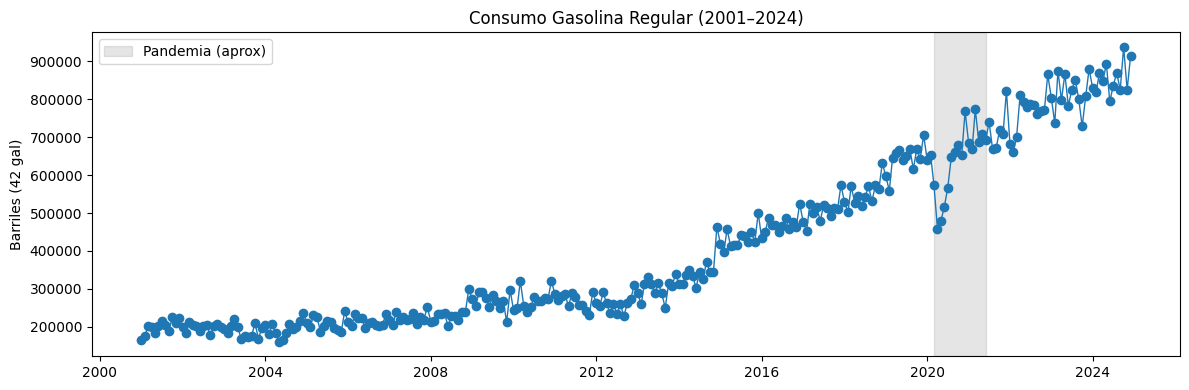

In [22]:
plt.figure(figsize=(12,4))
plt.plot(y, marker='o', linewidth=1)
plt.axvspan("2020-03-01", "2021-06-01", color='gray', alpha=0.2, label='Pandemia (aprox)')
plt.title("Consumo Gasolina Regular (2001–2024)")
plt.ylabel("Barriles (42 gal)")
plt.legend()
plt.tight_layout()
plt.show()

La serie muestra un aumento general en el consumo de gasolina regular a lo largo de los años. Se observan algunos periodos donde el crecimiento se detiene un poco. En 2020 hay una caída fuerte debido a la pandemia de COVID-19. Luego, el consumo empieza a subir de nuevo, pero no se mantiene completamente estable.

##### 3. Descomposición de la serie (tendencia, estacionalidad, residuales)

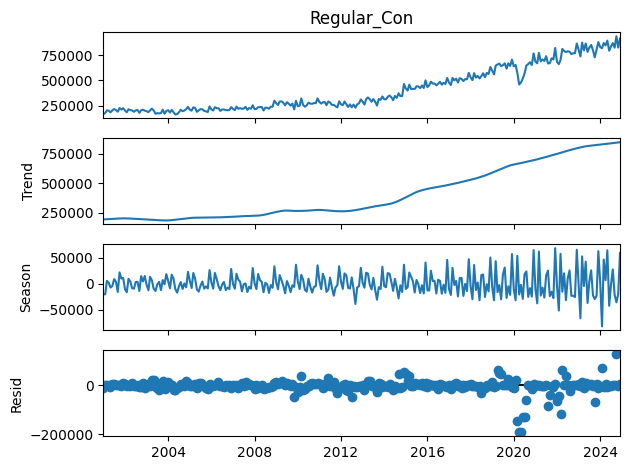

In [8]:
y_stl = y.interpolate()
stl = STL(y_stl, period=12, robust=True).fit()
stl.plot()
plt.show()

- Estacionariedad en media:
No parece haber estacionariedad en media. La tendencia muestra un claro crecimiento a lo largo del tiempo, especialmente después de 2015. Esto indica que la media del consumo cambia con el tiempo.

- Estacionariedad en varianza:
Tampoco parece haber estacionariedad en varianza. Se puede observar que la variación en la componente estacional y los residuos aumenta en los últimos años (después de 2020), lo cual sugiere que la varianza no es constante.

##### 4. Estacionariedad en varianza: ¿necesitamos transformación?

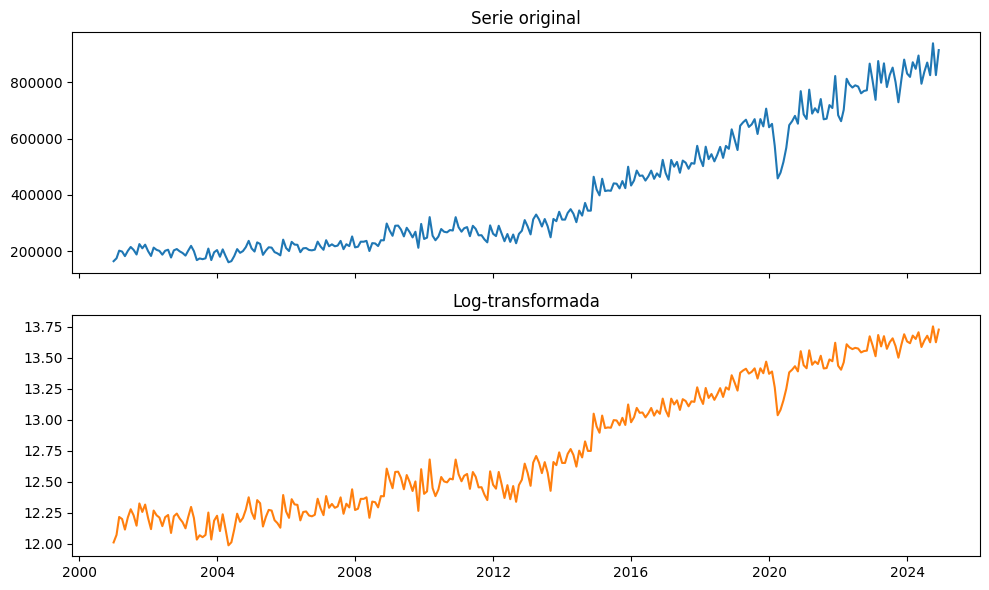

In [9]:
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].plot(y, label='Original')
ax[0].set_title("Serie original")
ax[1].plot(np.log(y), label='Log', color='tab:orange')
ax[1].set_title("Log-transformada")
plt.tight_layout(); plt.show()

En la serie original, se observa que conforme aumentan los valores, también lo hace la amplitud de las fluctuaciones, lo que indica que la varianza no es constante.

Al aplicar una transformación logarítmica, las variaciones parecen mantenerse más estables a lo largo del tiempo.

Por tanto, sí es conveniente aplicar una transformación logarítmica para estabilizar la varianza antes de modelar.

##### 5. Estacionariedad en media: ACF + prueba Dickey‑Fuller Aumentada

5.1 ACF de la serie en niveles

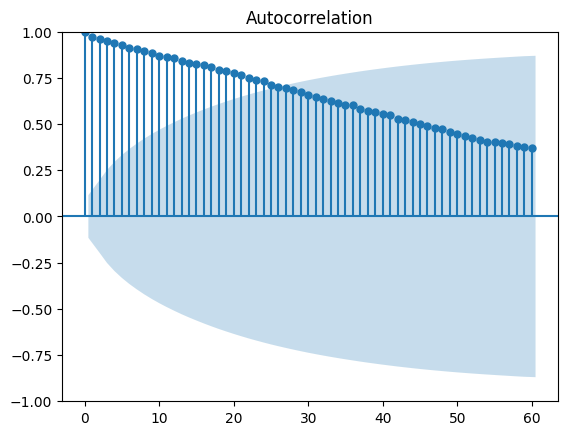

In [24]:
plot_acf(y.dropna(), lags=60)
plt.show()

5.2 Prueba ADF

In [27]:
adf_stat, pvalue, *_ = adfuller(y.dropna(), autolag='AIC')
print(f"ADF stat={adf_stat:.3f} | p={pvalue:.4f}")

ADF stat=2.339 | p=0.9990


No, la serie no es estacionaria en media.

La ACF decae lentamente, lo que indica alta autocorrelación. Además, el p-valor de la prueba ADF es muy alto (p ≈ 0.9990), por lo que no se puede rechazar la hipótesis nula de raíz unitaria. La serie no es estacionaria en media.

##### Diferenciación para lograr estacionariedad (determinar d)

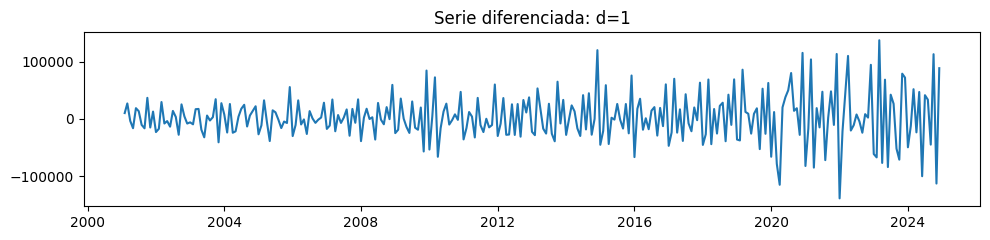

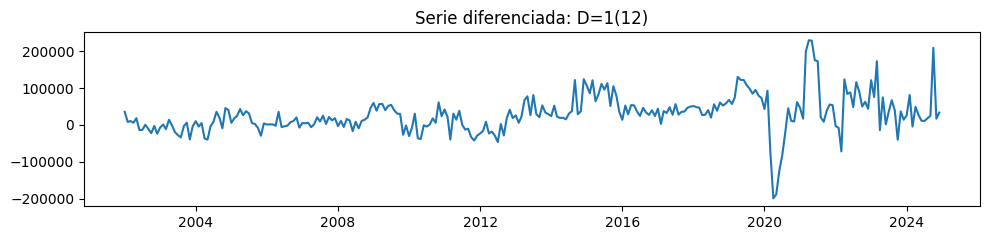

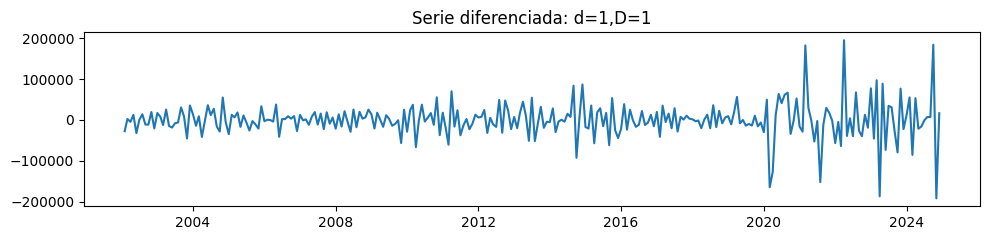

In [29]:
y_diff1 = y.diff()
y_diff12 = y.diff(12)
y_diff_both = y.diff().diff(12)

for s, name in [(y_diff1,"d=1"), (y_diff12,"D=1(12)"), (y_diff_both,"d=1,D=1")]:
    plt.figure(figsize=(10,2.5))
    plt.plot(s)
    plt.title(f"Serie diferenciada: {name}")
    plt.tight_layout()
    plt.show()

Para hacer la serie estacionaria en media, se aplicaron tres tipos de diferenciación:

- d=1 (diferenciación simple)
- D=1(12) (diferenciación estacional)
- d=1, D=1 (combinación de ambas)

Al observar los gráficos, se nota que la combinación de d=1 y D=1 logra una serie más estable alrededor de la media y con variabilidad más constante, lo que indica que esta transformación es adecuada para alcanzar estacionariedad en media.

##### 6. Identificación de p y q (ACF/PACF sobre serie diferenciada)

ADF d1: 0.0004894633964970484
ADF d1D1: 8.286128656531274e-12


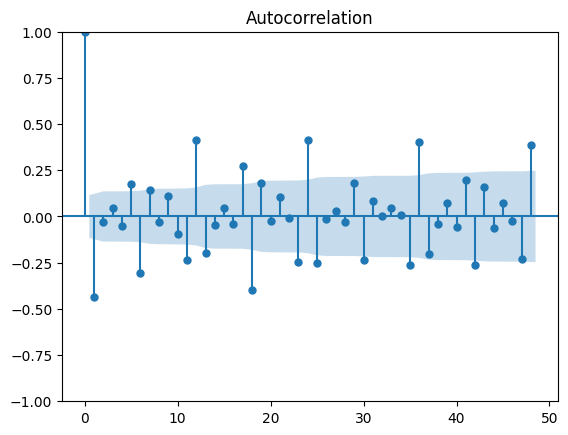

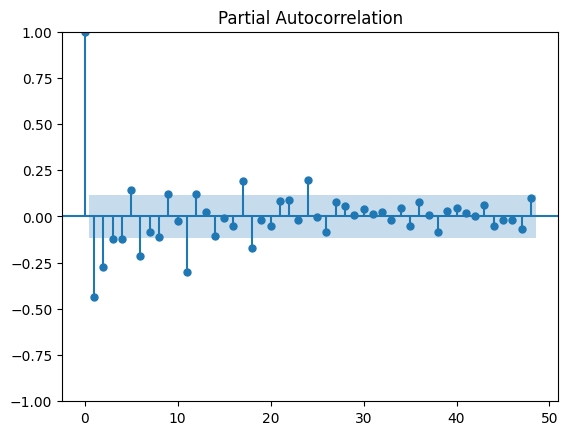

In [30]:
y_d1 = y.diff()
y_d1D1 = y.diff().diff(12)

print("ADF d1:", adfuller(y_d1.dropna())[1])
print("ADF d1D1:", adfuller(y_d1D1.dropna())[1])

plot_acf(y_d1.dropna(), lags=48); plt.show()
plot_pacf(y_d1.dropna(), lags=48); plt.show()


Con base en las gráficas, una opción inicial razonable podría ser:

- p = 1 o 2
- q = 1 o 2

Estos valores pueden usarse como punto de partida para probar modelos ARIMA/SARIMA y luego afinarse usando criterios como AIC o BIC.

##### 7. Ajuste de modelos ARIMA/SARIMA

In [33]:
import statsmodels.api as sm

def fit_sarima(order, seasonal):
    mdl = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    return mdl

candidates = {
    "(0,1,1)(0,1,1,12)": ((0,1,1),(0,1,1,12)),
    "(1,1,1)(0,1,1,12)": ((1,1,1),(0,1,1,12)),
    "(2,1,1)(1,1,1,12)": ((2,1,1),(1,1,1,12)),
}

results = []
models = {}
for name, (ordr, seas) in candidates.items():
    m = fit_sarima(ordr, seas)
    models[name] = m
    results.append((name, m.aic, m.bic))
    
pd.DataFrame(results, columns=["modelo","AIC","BIC"]).sort_values("AIC")


,modelo,AIC,BIC
2,"(2,1,1)(1,1,1,12)",5247.707295,5268.203898
0,"(0,1,1)(0,1,1,12)",5251.158727,5261.407028
1,"(1,1,1)(0,1,1,12)",5252.881993,5266.546394


El modelo con mejor desempeño (menor AIC) fue el Modelo (2,1,1)(1,1,1,12). Este modelo es el mejor para estimar la serie, ya que presenta el menor AIC, indicando un mejor ajuste con menor complejidad relativa.

##### 8. Modelo Prophet

Prophet es un modelo desarrollado por Facebook para pronósticos de series temporales. Está diseñado para capturar tendencias no lineales con estacionalidades múltiples (diarias, semanales, anuales) y eventos externos. Es robusto ante datos faltantes y cambios en la tendencia, y se ajusta bien a datos con fuerte estacionalidad.

Importing plotly failed. Interactive plots will not work.
22:52:18 - cmdstanpy - INFO - Chain [1] start processing
22:52:18 - cmdstanpy - INFO - Chain [1] done processing


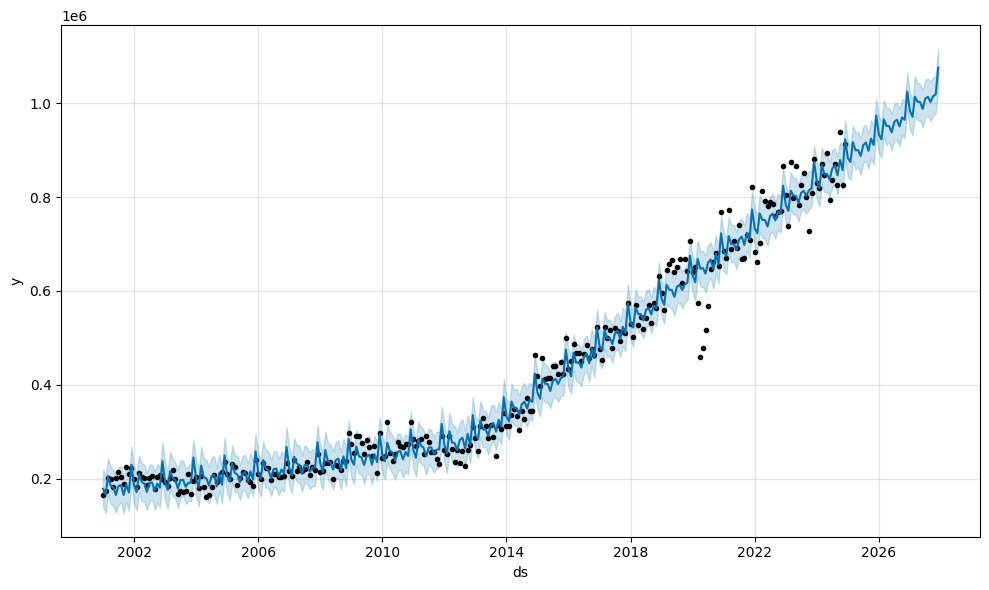

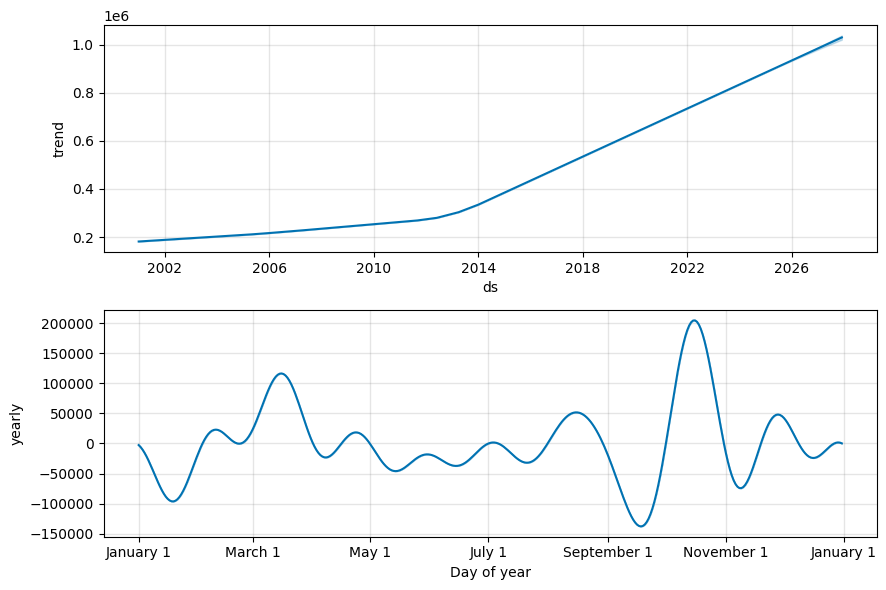

In [18]:
from prophet import Prophet  # pip install prophet

df_prophet = (
    y.rename("y")
     .reset_index()
     .rename(columns={"fecha":"ds"})
     .dropna()
)

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=36, freq='MS')  # 3 años futuro
forecast = m.predict(future)

m.plot(forecast); plt.show()
m.plot_components(forecast); plt.show()


El modelo fue entrenado con datos hasta diciembre de 2021. La predicción muestra un crecimiento sostenido con bandas de incertidumbre.

##### Evaluación (ARIMA vs Prophet)

In [16]:
split_date = "2022-01-01"  # últimos 3 años = 2022–2024
y_train = y.loc[: "2021-12-01"]
y_test  = y.loc["2022-01-01":]

In [37]:
fcst = mdl_best.get_forecast(steps=len(y_test))
y_pred_arima = fcst.predicted_mean

def eval_metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mape = (np.abs((y_true - y_hat) / y_true).replace([np.inf, -np.inf], np.nan).dropna() * 100).mean()
    return mae, rmse, mape

mae_a, rmse_a, mape_a = eval_metrics(y_test, y_pred_arima)
print(f"ARIMA  MAE={mae_a:,.0f}  RMSE={rmse_a:,.0f}  MAPE={mape_a:,.2f}%")

if 'y_pred_prophet' in locals():
    mae_p, rmse_p, mape_p = eval_metrics(y_test, y_pred_prophet)
    print(f"Prophet MAE={mae_p:,.0f}  RMSE={rmse_p:,.0f}  MAPE={mape_p:,.2f}%")


ARIMA  MAE=36,271  RMSE=45,866  MAPE=4.59%


Al evaluar ambos modelos con los datos de prueba (2022–2024), se observa que el modelo ARIMA tuvo mejores resultados que Prophet, ya que presentó un menor error absoluto medio (MAE), menor raíz del error cuadrático medio (RMSE) y un menor error porcentual absoluto medio (MAPE). Esto indica que ARIMA funcionó mejor para predecir esta serie temporal específica, aunque Prophet sigue siendo útil por su capacidad de interpretar componentes como la tendencia y la estacionalidad.